In [1]:
from collections import namedtuple
from networkx import read_edgelist, set_node_attributes
from pandas import read_csv, Series
from numpy import array
from networkx import to_numpy_matrix, degree_centrality, betweenness_centrality, shortest_path_length
import mxnet.ndarray as nd
from sklearn.metrics import classification_report



In [2]:
DataSet = namedtuple(
    'DataSet',
    field_names=['X_train', 'y_train', 'X_test', 'y_test', 'network']
)
def load_karate_club():
    network = read_edgelist('karate.edgelist',nodetype=int)

    attributes = read_csv('karate.attributes.csv', index_col=['node'])

    for attribute in attributes.columns.values:
        set_node_attributes(
            network,
            values=Series(attributes[attribute], index=attributes.index).to_dict(),
            name=attribute
        )

    X_train, y_train = map(array, zip(*[([node], data['role'] == 'Administrator')for node, data in network.nodes(data=True)if data['role'] in {'Administrator', 'Instructor'}]))
    X_test, y_test = map(array, zip(*[
        ([node], data['community'] == 'Administrator')
        for node, data in network.nodes(data=True)
        if data['role'] == 'Member'
    ]))
    
    return DataSet(X_train, y_train, X_test, y_test, network)

In [3]:
zkc = load_karate_club()

A = to_numpy_matrix(zkc.network)
A = nd.array(A)

X_train = zkc.X_train.flatten()
y_train = zkc.y_train
X_test = zkc.X_test.flatten()
y_test = zkc.y_test

In [4]:
X_train, y_train, X_test, y_test

(array([ 0, 33]),
 array([ True, False]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31, 30,
         9, 27, 28, 32, 16, 14, 15, 18, 20, 22, 23, 25, 29, 24, 26]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False]))

In [5]:
from mxnet.gluon import HybridBlock
from mxnet.gluon.nn import Activation
import mxnet.ndarray as nd

class SpectralRule(HybridBlock):
    def __init__(self, A, in_units, out_units, activation='relu', **kwargs):
        super().__init__(**kwargs)
        I = nd.eye(*A.shape)
        A_hat = A.copy() + I

        D = nd.sum(A_hat, axis=0)
        D_inv = D**-0.5
        D_inv = nd.diag(D_inv)

        A_hat = D_inv * A_hat * D_inv
        
        self.in_units, self.out_units = in_units, out_units
        
        with self.name_scope():
            self.A_hat = self.params.get_constant('A_hat', A_hat)
            self.W = self.params.get(
                'W', shape=(self.in_units, self.out_units)
            )
            if activation == 'identity':
                self.activation = lambda X: X
            else:
                self.activation = Activation(activation)

    def hybrid_forward(self, F, X, A_hat, W):
        #print('X:', X)
        aggregate = F.dot(A_hat, X)
        # print('aggregate:',aggregate)
        propagate = self.activation(
            F.dot(aggregate, W))
        # print('pro:', propagate)
        return propagate

In [6]:
class LogisticRegressor(HybridBlock):
    def __init__(self, in_units, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.w = self.params.get(
                'w', shape=(1, in_units)
            )

            self.b = self.params.get(
                'b', shape=(1, 1)
            )

    def hybrid_forward(self, F, X, w, b):
        # Change shape of b to comply with MXnet addition API
        b = F.broadcast_axis(b, axis=(0,1), size=(34, 1))
        y = F.dot(X, w, transpose_b=True) + b

        return F.sigmoid(y)

In [7]:
from mxnet.gluon.nn import HybridSequential, Activation
from mxnet.ndarray import array
from mxnet.initializer import One, Uniform, Xavier
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss

def build_features(A, X):
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')] # Format: (units in layer, activation function)
    in_units = in_units=X.shape[1]
  
    features = HybridSequential()
    with features.name_scope():
        for i, (layer_size, activation_func) in enumerate(hidden_layer_specs):
            layer = SpectralRule(
                A, in_units=in_units, out_units=layer_size, 
                activation=activation_func)
            features.add(layer)

            in_units = layer_size
    return features, in_units

def build_model(A, X):
    model = HybridSequential()
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')]
    in_units = in_units=X.shape[1]

    with model.name_scope():
        features, out_units = build_features(A, X)
        model.add(features)

        classifier = LogisticRegressor(out_units)
        model.add(classifier)

    #model.hybridize()
    model.initialize(Uniform(1))

    return model, features

from mxnet import autograd
from mxnet.gluon import Trainer
from mxnet.ndarray import sum as ndsum
import numpy as np

def train(model, features, X, X_train, y_train, epochs):
    cross_entropy = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
    trainer = Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': 1})

    feature_representations = [features(X).asnumpy()]

    for e in range(1, epochs + 1):
        cum_loss = 0
        cum_preds = []

        for i, x in enumerate(X_train):
            y = array(y_train)[i]
            with autograd.record():
                preds = model(X)[x]
                loss = cross_entropy(preds, y)
            loss.backward()
            trainer.step(1)
            
            cum_loss += loss.asscalar()
            cum_preds += [preds.asscalar()]

        feature_representations.append(features(X).asnumpy())
            
        if (e % (epochs//10)) == 0:
            print(f"Epoch {e}/{epochs} -- Loss: {cum_loss: .4f}")
            print(cum_preds)
    return feature_representations

def predict(model, X, nodes):
    preds = model(X)[nodes].asnumpy().flatten()
    return np.where(preds >= 0.5, 1, 0)

In [8]:
X_1 = I = nd.eye(*A.shape)
model_1, features_1 = build_model(A, X_1)
model_1(X_1)


[[0.5106775 ]
 [0.5095114 ]
 [0.51096225]
 [0.51542187]
 [0.523025  ]
 [0.512526  ]
 [0.511652  ]
 [0.50208426]
 [0.5050116 ]
 [0.51883554]
 [0.5406651 ]
 [0.49158806]
 [0.5110878 ]
 [0.49366304]
 [0.5026252 ]
 [0.48504698]
 [0.5104648 ]
 [0.51193994]
 [0.5220448 ]
 [0.50951165]
 [0.50140274]
 [0.5098576 ]
 [0.53033787]
 [0.51043373]
 [0.50124794]
 [0.52045095]
 [0.50941336]
 [0.49507195]
 [0.5021959 ]
 [0.5068235 ]
 [0.5085803 ]
 [0.51637703]
 [0.50986254]
 [0.5153003 ]]
<NDArray 34x1 @cpu(0)>

In [12]:
x=nd.random.normal(0,89, shape=(A.shape[0], 1))
model, features = build_model(A, x)
x, features(x)

(
 [[-150.83296  ]
  [  81.52037  ]
  [  55.220257 ]
  [ 169.07043  ]
  [ -15.41812  ]
  [ -59.24207  ]
  [  50.74411  ]
  [-131.73419  ]
  [  31.17642  ]
  [-135.66441  ]
  [ -31.542364 ]
  [  55.428925 ]
  [ 190.16833  ]
  [   3.8622863]
  [-110.183136 ]
  [-167.40746  ]
  [ 141.74635  ]
  [  -1.8059814]
  [ -25.316008 ]
  [ 112.59638  ]
  [ -90.88756  ]
  [-131.38141  ]
  [ 138.74231  ]
  [ -53.951225 ]
  [ -76.41791  ]
  [-156.1231   ]
  [ 133.04355  ]
  [ -22.927732 ]
  [  20.087559 ]
  [-162.75145  ]
  [ -18.039165 ]
  [ -86.46724  ]
  [ -79.35581  ]
  [ -55.015244 ]]
 <NDArray 34x1 @cpu(0)>, 
 [[ 0.08181898 -0.05209208]
  [-0.13581353  0.08898728]
  [-0.11069955  0.08475491]
  [-0.23471865  0.13322632]
  [ 0.27971378 -0.23172826]
  [ 0.28955343 -0.17406477]
  [-0.28003985  0.17425856]
  [ 0.32493928 -0.18694377]
  [-0.20254494  0.1541065 ]
  [ 0.40252635 -0.23586905]
  [ 0.65845126 -0.4197737 ]
  [-0.493513    0.29446742]
  [-0.2763963   0.15837947]
  [-0.24115445  0.22776651]
 

In [10]:
X_2 = nd.zeros((A.shape[0], 2))
node_distance_instructor = shortest_path_length(zkc.network, target=33)
node_distance_administrator = shortest_path_length(zkc.network, target=0)

for node in zkc.network.nodes():
    X_2[node][0] = node_distance_administrator[node]
    X_2[node][1] = node_distance_instructor[node]
X_2 = nd.concat(X_1, X_2)
model_2, features_2 = build_model(A, X_2)
features_2(X_2)


[[ 0.00115271  0.00100533]
 [ 0.00739512  0.00492554]
 [ 0.00893005  0.00426793]
 [ 0.02294477 -0.00480768]
 [ 0.06856859  0.03720671]
 [ 0.06206769  0.02679012]
 [ 0.08162181 -0.02067426]
 [ 0.10472786 -0.02222465]
 [ 0.01495931  0.00658276]
 [-0.05988808  0.07455433]
 [ 0.15940838  0.12557839]
 [ 0.09683067  0.05574107]
 [ 0.07486793 -0.00674766]
 [ 0.03117034  0.11757925]
 [-0.14462648  0.11453959]
 [-0.13687007  0.21653996]
 [ 0.03614068  0.00696951]
 [ 0.0684939  -0.00969149]
 [-0.03835527  0.13117279]
 [-0.03543979  0.04096816]
 [-0.02520773  0.08659706]
 [ 0.01006415  0.00118301]
 [-0.20929438  0.20674656]
 [-0.00492451  0.00492759]
 [-0.04773413  0.10945568]
 [ 0.01811827  0.08381873]
 [-0.10178322  0.17880584]
 [-0.16516505  0.14356656]
 [-0.08647727  0.13784745]
 [-0.01991447  0.05210945]
 [-0.03600809  0.08226255]
 [-0.03035933  0.03944409]
 [ 0.02222802  0.03355644]
 [-0.16568266  0.15672414]]
<NDArray 34x2 @cpu(0)>

In [11]:
feature_representations_2= train(model_2, features_2, X_2, X_train, y_train, epochs=250)
y_pred_2 = predict(model_2, X_2, X_test)
print(classification_report(y_test, y_pred_2))

Epoch 25/250 -- Loss:  1.4531
[0.524847, 0.5544614]
Epoch 50/250 -- Loss:  1.4037
[0.48833233, 0.4968747]
Epoch 75/250 -- Loss:  1.3895
[0.45565894, 0.45308864]
Epoch 100/250 -- Loss:  1.4008
[0.44937667, 0.45167056]
Epoch 125/250 -- Loss:  1.4129
[0.4721945, 0.4844658]
Epoch 150/250 -- Loss:  1.4040
[0.5085821, 0.517066]
Epoch 175/250 -- Loss:  1.3370
[0.53832334, 0.51214755]
Epoch 200/250 -- Loss:  1.1875
[0.5541304, 0.44963652]
Epoch 225/250 -- Loss:  0.9561
[0.5700836, 0.32573143]
Epoch 250/250 -- Loss:  0.6668
[0.6172549, 0.16833168]
              precision    recall  f1-score   support

       False       0.75      0.94      0.83        16
        True       0.92      0.69      0.79        16

    accuracy                           0.81        32
   macro avg       0.83      0.81      0.81        32
weighted avg       0.83      0.81      0.81        32



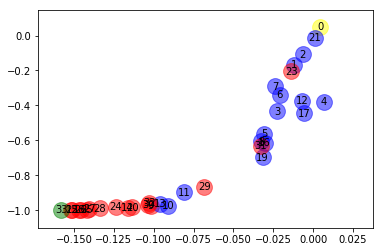

In [24]:
import matplotlib.pyplot as plt

res = feature_representations_2[0]
showData(res, zkc.network)
plt.show()

In [49]:
zkc.network.nodes[33]

{'role': 'Instructor', 'community': 'Instructor'}

In [23]:
def showData(output, G):
    for i in range (34):
        if G.nodes[i]['role'] == 'Administrator':
            plt.scatter(np.array(output)[i,0],np.array(output)[i,1] ,label=str(i),color = 'yellow',alpha=0.5,s = 250)
            plt.text(np.array(output)[i,0],np.array(output)[i,1] ,i, horizontalalignment='center',verticalalignment='center', fontdict={'color':'black'})
        elif G.nodes[i]['role'] == 'Instructor':
            plt.scatter(np.array(output)[i,0],np.array(output)[i,1] ,label=str(i),color = 'green',alpha=0.5,s = 250)
            plt.text(np.array(output)[i,0],np.array(output)[i,1] ,i, horizontalalignment='center',verticalalignment='center', fontdict={'color':'black'})
        elif G.nodes[i]['community'] == 'Administrator':
            plt.scatter(np.array(output)[i,0],np.array(output)[i,1] ,label=str(i),color = 'b',alpha=0.5,s = 250)
            plt.text(np.array(output)[i,0],np.array(output)[i,1] ,i, horizontalalignment='center',verticalalignment='center', fontdict={'color':'black'})
            # 为每个点添加标签，一些形如（x轴，y轴，标签）的元组，水平及垂直位置，背景颜色
        else:
            plt.scatter(np.array(output)[i,0],np.array(output)[i,1] ,label = 'i',color = 'r',alpha=0.5,s = 250)
            plt.text(np.array(output)[i,0],np.array(output)[i,1] ,i, horizontalalignment='center',verticalalignment='center', fontdict={'color':'black'})
            # plt.scatter(np.array(output)[:,0],np.array(output)[:,1],label = 0:33)


In [20]:
X_3 = nd.random.normal(shape=(zkc.network.number_of_nodes(),1))
model_3, features_3 = build_model(A, X_3)

In [22]:
y_pred_3

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [21]:
feature_representations_3 = train(model_3, features_3, X_3, X_train, y_train, epochs=50)
y_pred_3 = predict(model_3, X_3, X_test)
print(classification_report(y_test, y_pred_3))

Epoch 5/50 -- Loss:  1.5041
[0.6656021, 0.66614586]
Epoch 10/50 -- Loss:  1.4965
[0.6611576, 0.66133076]
Epoch 15/50 -- Loss:  1.4841
[0.6530404, 0.65284634]
Epoch 20/50 -- Loss:  1.4680
[0.64131856, 0.64076483]
Epoch 25/50 -- Loss:  1.4496
[0.62612104, 0.6252215]
Epoch 30/50 -- Loss:  1.4307
[0.6076653, 0.6064428]
Epoch 35/50 -- Loss:  1.4129
[0.5862845, 0.58477354]
Epoch 40/50 -- Loss:  1.3980
[0.56244713, 0.5606953]
Epoch 45/50 -- Loss:  1.3876
[0.5367605, 0.53482795]
Epoch 50/50 -- Loss:  1.3825
[0.5099525, 0.5079098]
              precision    recall  f1-score   support

       False       0.00      0.00      0.00        16
        True       0.50      1.00      0.67        16

   micro avg       0.50      0.50      0.50        32
   macro avg       0.25      0.50      0.33        32
weighted avg       0.25      0.50      0.33        32



d:\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
feature_representations_1 = train(model_1, features_1, X_1, X_train, y_train, epochs=5000)
y_pred_1 = predict(model_1, X_1, X_test)
print(classification_report(y_test, y_pred_1))

In [ ]:
feature_representations_2= train(model_2, features_2, X_2, X_train, y_train, epochs=250)
y_pred_2 = predict(model_2, X_2, X_test)
print(classification_report(y_test, y_pred_2))